In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import MuC.MuC as dg
from MuC import collider_tools as col
from MuC import detector_tools as det
from MuC import plot_tools as pt

from MuC.MuC import BINSimulator
from MuC import xsecs

import pandas as pd

from DarkNews import plot_tools as pt
from fastbnb import plot_tools as pt2

In [32]:
marker_styles = {'NOMAD': '^', 
                 'CTFR': '>', 
                 'CCFR': '<', 
                 'E616': 'v', 
                 'BEBC': 'o', 
                 'NuTeV': 's', 
                 'CDHS': '^', 
                 'FNAL-E0053': '>', 
                 'SERPUKHOV-045': '<',
                 'SERPUKHOV-107': 'v',
                 'IHEP-JINR': 'o', 
                 'CHORUS': 's', 
                 'FASER24': '*', 
}

marker_styles_fill = {'NOMAD': 'lightgrey',
                 'CTFR': 'lightgrey',
                 'CCFR': 'lightgrey',
                 'E616': 'lightgrey',
                 'BEBC': 'lightgrey',
                 'NuTeV': 'lightgrey',
                 'CDHS': 'white',
                 'FNAL-E0053': 'white',
                 'SERPUKHOV-045': 'white',
                 'SERPUKHOV-107': 'white',
                 'IHEP-JINR': 'white',
                 'CHORUS': 'white',
                 'FASER24': 'lightgrey',
                 }

In [87]:

def load_HEPdata_file(exp, nuflavor):
    data = pd.read_csv(f'xsec_database/{exp}_{nuflavor}.csv', skiprows=0, header=10)

    if exp == 'NOMAD':
        x = data['E(P=1) [GEV]']
        xlow = x - data['E(P=1) [GEV] LOW']
        xhigh = data['E(P=1) [GEV] HIGH'] - x

        y =  (data['SIG/E(P=1) [10**-38CM**2/GEV]'])*x*1e-38
        ylow = np.sqrt(data['stat -']**2 + data['sys -']**2)*x*1e-38
        yhigh = np.sqrt(data['stat +']**2 + data['sys +']**2)*x*1e-38

    elif exp == 'CTFR':
        # NOTE: 4% sys included by hand
        y =  data['SIG [CM**2]']
        ylow = np.abs(data['error +'])
        ylow += y*0.04

        yhigh = np.abs(data['error -'])
        yhigh += y*0.04

        
        x = data['E [GEV]']
        xlow = None
        xhigh = None

    elif exp == 'CCFR':
        x = data['E(P=1) [GEV]']
        y =  data['SIG/E/A [PB/GEV]']*1e-36*x # cm^2

        ylow = np.sqrt(data['stat -']**2 + data['sys -']**2)*1e-36*x
        yhigh = np.sqrt(data['stat +']**2 + data['sys +']**2)*1e-36*x
        
        xlow = None
        xhigh = None

    elif exp == 'E616':
        x = data['E [GEV]']
        y =  data['SIG/E [CM**2/GEV]']*x # cm^2

        ylow = np.abs(data['error -']*x)
        yhigh = np.abs(data['error +']*x)
        
        xlow = None
        xhigh = None
    
    elif exp == 'IHEP-JINR':
        
        x = data['E [GEV]']
        y =  data['SIG/E [FB/GEV]']*x*1e-39 # cm^2

        ylow = np.sqrt(data['stat -']**2 + data['sys -']**2)*1e-39*x
        yhigh = np.sqrt(data['stat +']**2 + data['sys +']**2)*1e-39*x
        
        xlow = x - data['E [GEV] LOW']
        xhigh = data['E [GEV] HIGH'] - x
    
    elif exp == 'CDHS':
        x = data['PLAB [GEV]']
        y =  data['SIG/E [10**-38 CM**2/GEV]']*x*1e-38 # cm^2

        ylow = np.sqrt(data['stat -']**2 + data['sys -']**2)*1e-38*x
        yhigh = np.sqrt(data['stat +']**2 + data['sys +']**2)*1e-38*x
        
        xlow = None
        xhigh = None

    elif exp == 'FNAL-E0053':
        x = data['E [GEV]']
        y =  data['SIG/E [CM**2/GEV]']*x # cm^2
        
        ylow = np.abs(data['error -']*x)
        yhigh = np.abs(data['error +']*x)
        
        xlow = None
        xhigh = None	

    elif exp == 'BEBC':
        x = data['PLAB [GEV]']
        y =  data['SIG/E [10**-38 CM**2/GEV]']*x*1e-38 # cm^2

        ylow = np.sqrt(data['stat -']**2 + data['sys -']**2)*1e-38*x
        yhigh = np.sqrt(data['stat +']**2 + data['sys +']**2)*1e-38*x
        
        xlow = x - data['PLAB [GEV] LOW']
        xhigh = data['PLAB [GEV] HIGH'] - x
    
    elif exp == 'SERPUKHOV-045':
        x = data['E [GEV]']
        y =  data['SIG/E [FB/GEV]']*x*1e-39 # cm^2

        ylow = np.abs(data['error +'])*x*1e-39
        ylow += y*0.04
        yhigh = np.abs(data['error -'])*x*1e-39
        yhigh += y*0.04

        xlow = x - data['E [GEV] LOW']
        xhigh = data['E [GEV] HIGH'] - x

    elif exp == 'SERPUKHOV-107':
        x = data['PLAB [GEV]']
        y =  data['SIG/E [10**-38 CM**2/GEV]']*x*1e-38 # cm^2

        ylow = np.abs(data['error +'])*x*1e-38
        yhigh = np.abs(data['error -'])*x*1e-38

        xlow = x - data['PLAB [GEV] LOW']
        xhigh = data['PLAB [GEV] HIGH'] - x

    elif exp == 'NuTeV':
        x = data['PLAB [GEV]']
        y =  data['SIG/E [10**-38 CM**2/GEV]']*x*1e-38 # cm^2

        ylow = np.abs(data['error +']*x*1e-38-y)
        yhigh = np.abs(data['error +']*x*1e-38-y)

        xlow = None
        xhigh = None
    
    elif exp =='FASER24':
        x = data['E [GEV]']
        y =  data['SIG/E [CM**2/GEV]']*x*1e-38 # cm^2

        ylow = np.abs(y - data['error -']*1e-38*x)
        yhigh = np.abs(y - data['error +']*1e-38*x)
        
        xlow = x - data['E [GEV] LOW']
        xhigh = data['E [GEV] HIGH'] - x
    
    return x, xlow, xhigh, y, ylow, yhigh


datapoint_kwargs = {
            "markeredgewidth": 0.5,
            "capsize": 1,
            "markeredgecolor": "grey",
            "ms": 3.5,
            "color": "grey",
            "lw": 0.0,
            "elinewidth": 0.8,
            "alpha": 1,
            "zorder": 0.9}

def plot_data(ax, exp, nuflavor):

    x, xlow, xhigh, y, ylow, yhigh = load_HEPdata_file(exp, nuflavor)
    x = np.array(x)
   
    label = exp if 'bar' not in nuflavor else None
    if exp == 'FASER24':
        label='FASER (2024)'
    
    if x[-1] > 50:
        if xlow is not None:
            c = ax.errorbar(x, y/x*units, yerr=[ylow/x*units,yhigh/x*units], xerr=[xlow, xhigh], marker=marker_styles[exp], markerfacecolor = marker_styles_fill[exp], label=label, **datapoint_kwargs)
        else:
            c = ax.errorbar(x, y/x*units, yerr=[ylow/x*units,yhigh/x*units], marker=marker_styles[exp], markerfacecolor = marker_styles_fill[exp], label=label, **datapoint_kwargs)
        return c
    else:
        return None

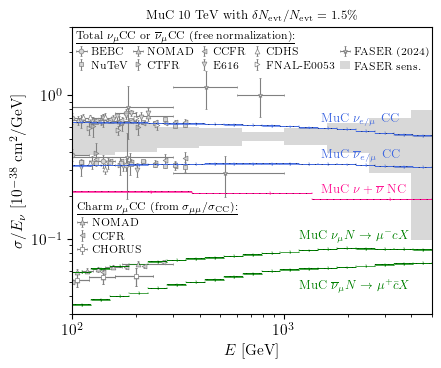

In [165]:
fig, ax = pt.std_fig()
ENUMIN = 100 # GeV
labels=[]
labels.append(plot_data(ax, 'BEBC', 'numu'))
labels.append(plot_data(ax, 'NuTeV', 'numu'))
labels.append(plot_data(ax, 'NOMAD', 'numu'))
labels.append(plot_data(ax, 'CTFR', 'numu'))
labels.append(plot_data(ax, 'CCFR', 'numu'))
labels.append(plot_data(ax, 'E616', 'numu'))
labels.append(plot_data(ax, 'IHEP-JINR', 'numu'))
labels.append(plot_data(ax, 'CDHS', 'numu'))
labels.append(plot_data(ax, 'FNAL-E0053', 'numu'))
labels.append(plot_data(ax, 'SERPUKHOV-045', 'numu'))
labels.append(plot_data(ax, 'SERPUKHOV-107', 'numu'))
labels.append(plot_data(ax, 'FASER24', 'numu'))

labels = [l for l in labels if l is not None]

plot_data(ax, 'CTFR', 'numubar')
plot_data(ax, 'CCFR', 'numubar')
plot_data(ax, 'E616', 'numubar')
plot_data(ax, 'IHEP-JINR', 'numubar')
plot_data(ax, 'CDHS', 'numubar')
plot_data(ax, 'BEBC', 'numubar')
plot_data(ax, 'SERPUKHOV-045', 'numubar')
plot_data(ax, 'NuTeV', 'numubar')
plot_data(ax, 'FASER24', 'numubar')

MuCdatapoint_kwargs = {
            "markeredgewidth": 0.25,
            "capsize": 1,
            "color": "royalblue",
            "markerfacecolor": "royalblue",
            "markeredgecolor": "royalblue",
            "ms": 0.5,
            "lw": 0.0,
            "elinewidth": 0.5,
            "alpha": 1}

error = 0.015
xbins = np.geomspace(ENUMIN, 5e3, 20, endpoint=True)
x = (xbins[1:]+xbins[:-1])/2
y=(xsecs.sigma_lightquark_CC_nu(x)+0*xsecs.sigma_charm_CC_nu(x))/x*units
ax.errorbar(x, y, yerr=y*error, xerr=[x - xbins[:-1], xbins[1:]-x], marker='o', label='MuC', zorder=1, **MuCdatapoint_kwargs)
ax.bar(x, bottom=(1-0.5*error)*y, height=error*y, width=np.diff(xbins), color='royalblue', hatch='/////', zorder=2)

y=(xsecs.sigma_lightquark_CC_nubar(x)+0*xsecs.sigma_charm_CC_nubar(x))/x*units
ax.errorbar(x, y, yerr=y*error, xerr=[x - xbins[:-1], xbins[1:]-x], marker='o', label='MuC', zorder=1, **MuCdatapoint_kwargs)
ax.bar(x, bottom=(1-0.5*error)*y, height=error*y, width=np.diff(xbins), color='royalblue', hatch='/////', zorder=2)


MuCdatapoint_kwargs['color'] = 'green'
MuCdatapoint_kwargs['markerfacecolor'] = 'green'
MuCdatapoint_kwargs['markeredgecolor'] = 'green'
y=(xsecs.sigma_charm_CC_nu(x))/x*units
# ax.bar(x, bottom=(1-error)*y, height=2*error*y, width=np.diff(xbins), color='green', hatch='/////')
ax.errorbar(x, y, yerr=y*error, xerr=[x - xbins[:-1], xbins[1:]-x], marker='o', label='MuC', zorder=1, **MuCdatapoint_kwargs)
ax.bar(x, bottom=(1-0.5*error)*y, height=error*y, width=np.diff(xbins), color='green', hatch='/////', zorder=2)
y=(xsecs.sigma_charm_CC_nubar(x))/x*units
# ax.bar(x, bottom=(1-error)*y, height=2*error*y, width=np.diff(xbins), color='green', hatch='\\\\\\\\\\')
ax.errorbar(x, y, yerr=y*error, xerr=[x - xbins[:-1], xbins[1:]-x], marker='o', label='MuC', zorder=1, **MuCdatapoint_kwargs)
ax.bar(x, bottom=(1-0.5*error)*y, height=error*y, width=np.diff(xbins), color='green', hatch='/////', zorder=2)

xbins = np.geomspace(ENUMIN, 5e3, 4, endpoint=True)
x = (xbins[1:]+xbins[:-1])/2
y=(xsecs.sigma_NC_nu(x)+xsecs.sigma_NC_nubar(x))/x/2*units
MuCdatapoint_kwargs['color'] = 'deeppink'
MuCdatapoint_kwargs['markerfacecolor'] = 'deeppink'
MuCdatapoint_kwargs['markeredgecolor'] = 'deeppink'
# ax.bar(x, bottom=(1-error)*y, height=2*error*y, width=np.diff(xbins), color='deeppink')
ax.errorbar(x, y, yerr=y*error, xerr=[x - xbins[:-1], xbins[1:]-x], marker='o', label='MuC', zorder=1, **MuCdatapoint_kwargs)
ax.bar(x, bottom=(1-0.5*error)*y, height=error*y, width=np.diff(xbins), color='deeppink', hatch='/////', zorder=2)

def DtoMu_BR(Enu):
    a = 0.097
    b = 6.7 # GeV
    return a/(1 + b/Enu)

bins= np.array([1.03485839e+1,2.99564270e+1,5.00000000e+1,7.03340595e+1,9.00871460e+1,1.19862019e+2,1.59949165e+2,2.39832970e+2])
x = (bins[1:]+bins[:-1])/2
_, y, sigma_high, sigma_low = np.genfromtxt("xsec_database/CHORUS_dimuon_numu.dat", unpack=True)
y *= (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
sigma_high *= (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
sigma_low *= (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
plt.errorbar(x, y, yerr=[y-sigma_low, sigma_high-y], xerr=[x-bins[:-1], bins[1:]-x], marker='^', **datapoint_kwargs)


dimuon_labels=[]

bl, br, x, y, ratio_stat, ratio_sys, _, _ = np.genfromtxt("xsec_database/NOMAD_dimuon_numu.dat", unpack=True)
y *= 1e-3 * (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
ratio_stat *= 1e-3 * (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
ratio_sys *= 1e-3 * (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
dy = np.sqrt(ratio_stat**2 + ratio_sys**2)
c = ax.errorbar(x, y, yerr=dy, xerr=[x-bl, br-x], marker=marker_styles['NOMAD'], markerfacecolor=marker_styles_fill['NOMAD'], label='NOMAD', **datapoint_kwargs)
dimuon_labels.append(c)

x, y, ypdy = np.genfromtxt("xsec_database/CCFR_dimuon_numu.dat", unpack=True)
y *= (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
ypdy *= (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
dy = ypdy - y
c = ax.errorbar(x, y, yerr=dy, marker=marker_styles['CCFR'], markerfacecolor=marker_styles_fill['CCFR'], label='CCFR', **datapoint_kwargs)
dimuon_labels.append(c)

bins= np.array([1.03485839e+1,2.99564270e+1,5.00000000e+1,7.03340595e+1,9.00871460e+1,1.19862019e+2,1.59949165e+2,2.39832970e+2])
x = (bins[1:]+bins[:-1])/2
_, y, sigma_high, sigma_low = np.genfromtxt("xsec_database/CHORUS_dimuon_numu.dat", unpack=True)
y *= (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
sigma_high *= (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
sigma_low *= (xsecs.sigma_lightquark_CC_nu(x)+xsecs.sigma_charm_CC_nu(x))*units/x/DtoMu_BR(x)
c = ax.errorbar(x, y, yerr=[y-sigma_low, sigma_high-y], xerr=[x-bins[:-1], bins[1:]-x], marker=marker_styles['CHORUS'], markerfacecolor=marker_styles_fill['CHORUS'], label='CHORUS', **datapoint_kwargs)
dimuon_labels.append(c)


# # FASERnu
xbins = np.logspace(np.log10(1e2), np.log10(6.34e3), 10, endpoint=True)
x = (xbins[1:]+xbins[:-1])/2

# _, y, sigma_high, sigma_low = np.genfromtxt("xsec_database/FASER_nue.dat", unpack=True)
# ylow = sigma_low*1e-38*units
# yhigh = sigma_high*1e-38*units
# y *= 1e-38*units
# ax.bar(x, bottom=ylow, height=yhigh-ylow, width=np.diff(xbins), label=r'FASER $\nu_\mu$', alpha=0.2, edgecolor='black', linewidth=0.1, facecolor='grey')

_, y, sigma_high, sigma_low = np.genfromtxt("xsec_database/FASER_numu.dat", unpack=True)
ylow = sigma_low*1e-38*units
yhigh = sigma_high*1e-38*units
y *= 1e-38*units
lsens=ax.bar(x, bottom=ylow, height=(yhigh-ylow), width=np.diff(xbins), label=r'FASER sens.', alpha=0.3, edgecolor='black', linewidth=0.0, facecolor='grey')
labels.append(lsens)

ax.annotate(r"MuC ${\nu}_{e/\mu}$ CC", (3*500, 0.66), xycoords='data', fontsize=9, color='royalblue')
ax.annotate(r"MuC $\overline{\nu}_{e/\mu}$ CC", (3*500, 0.37), xycoords='data', fontsize=9, color='royalblue')
ax.annotate(r"MuC $\nu+\overline{\nu}$ NC", (3*500, 0.21), xycoords='data', fontsize=9, color='deeppink')
ax.annotate(r"MuC $\nu_\mu N \to \mu^- c X$", (1.18e3, 0.1), xycoords='data', fontsize=9, color='green')
ax.annotate(r"MuC $\overline{\nu}_\mu N \to \mu^+ \bar c X$", (1.18e3, 0.045), xycoords='data', fontsize=9, color='green')


# ax.annotate(r"\noindent Data: NuTeV/CCFR/CTFR/NOMAD\\CDHS/BEBC/IHEP-JINR", (55, 1.2), xycoords='data', fontsize=8, color='grey')
# ax.annotate(r"\noindent Data: \\CCFR\\NOMAD\\CHORUS", (60, 0.15), xycoords='data', fontsize=8, color='grey')
# ax.annotate(r"\noindent FASER$\nu$ \\ sensitivity", (2.52e3, 1.2), xycoords='data', fontsize=8, color='grey')

ax.set_title(fr"MuC 10 TeV with $\delta N_{{\rm evt}}/N_{{\rm evt}} = {error*100:g}\%$", fontsize=9)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.03, 3)
ax.set_xlim(ENUMIN, 5e3)
ax.set_ylabel(r"$\sigma/E_{\nu}$ [$10^{-38}$ cm$^2$/GeV]")
# ax.set_ylabel(r"$\sigma/E_{\overset{\footnotesize (-)}{\nu}}$ [$10^{-38}$ cm$^2$/GeV]")
ax.set_xlabel(r"$E$ [GeV]")

l1 = ax.legend(title=r'\underline{Total $\nu_\mu$CC or $\overline{\nu}_\mu$CC (free normalization):}', title_fontsize=8, handles=labels, fontsize=7.5, frameon=True, loc=(0.005, 0.84), ncol=5, framealpha=0.0, columnspacing=0.5, labelspacing=0.4, edgecolor='None', handletextpad=0.4, handlelength=1., borderpad=0.2)
l1._legend_box.align = "left"
l2 = ax.legend(title=r'\underline{Charm $\nu_\mu$CC (from $\sigma_{\mu\mu}/\sigma_{\rm CC}$):}', title_fontsize=8, handles=dimuon_labels, fontsize=7.5, frameon=True, loc=(0.0075, 0.2), ncol=1, framealpha=0.0, columnspacing=0.5, labelspacing=0.4, edgecolor='None', handletextpad=0.4, handlelength=1., borderpad=0.2)
l2._legend_box.align = "left"
plt.gca().add_artist(l1)
# plt.gca().add_artist(l2)

fig.savefig("plots/paper_plots/xsec_measurement.pdf", bbox_inches='tight')